In [1]:
using Flux, DiffEqFlux, OrdinaryDiffEq, DiffEqParamEstim, Plots, Optim, Dates
using BSON: @save

┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1273
┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273


In [2]:
# Structure to observe training
mutable struct saver
    losses::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,times,count_epochs)
end
function update_saver(saver, loss_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

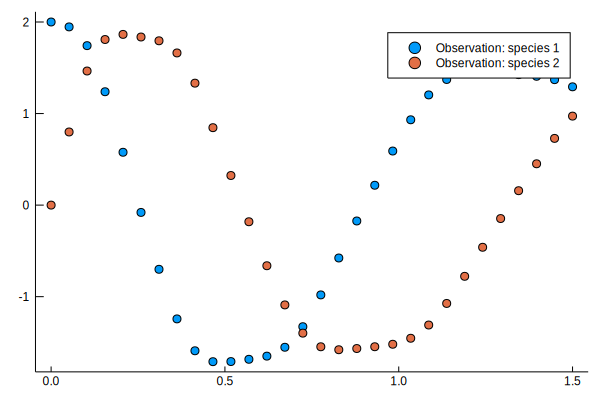

In [3]:
# Observation
# Start conditions for the two species in the system
u0 = Float32[2.; 0.]
# Number of evaluations of the neural ODE.
datasize = 30
# Time span in which of evaluation will be and actual timepoints of evaluations
tspan = (0.0f0, 1.5f0)
t = range(tspan[1], tspan[2], length = datasize)
# The true ODE (with the true parameters) which the neural net should learn
function trueODEfunc(du, u, p, t)
  true_A = [-0.1 2.0; -2.0 -0.1]
  du .= ((u.^3)'true_A)'
end
# Construction of the ODEProblem and solving the ODEProblem with Tsit5 solver
prob = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob,Tsit5(),saveat = t))
scatter(t, ode_data[1,:], label="Observation: species 1", grid = "off", xlab= "Time", ylab= "Abundance")
scatter!(t, ode_data[2,:], label="Observation: species 2")

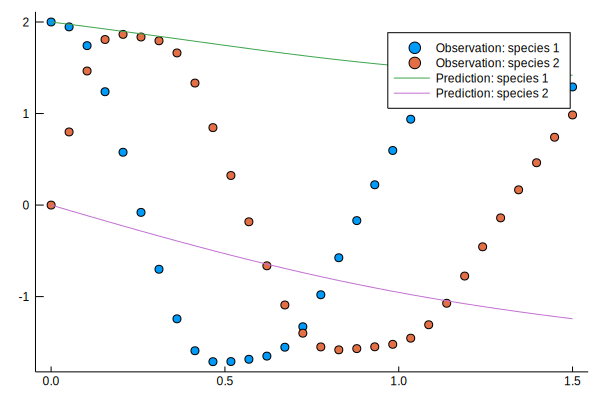

In [10]:
# Building a neural ODE and see starting point
# Derivative is modeled by a neural net. 
dudt = Chain(x -> x.^3,
       Dense(2,50, tanh),
       Dense(50,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat = t, reltol = 1e-7, abstol = 1e-9)
n_epochs = 1000
sa_l2 = saver(n_epochs)
# L2 loss
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
# Callback function to observe L2 training.
cb = function ()
    sa_l2.count_epochs = sa_l2.count_epochs +  1
    update_saver(sa_l2, Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
    #println("\"", Tracker.data(L2_loss_fct()), "\" \"", Dates.Time(Dates.now()), "\";")
end

pred = n_ode(u0)
scatter(t, ode_data[1,:], label = "Observation: species 1", grid = "off")
scatter!(t, ode_data[2,:], label = "Observation: species 2")
plot!(t, Flux.data(pred[1,:]), label = "Prediction: species 1")
plot!(t, Flux.data(pred[2,:]), label = "Prediction: species 2")

In [11]:
# train n_ode with L2 norm
opt = ADAM(0.1)
data = Iterators.repeated((), n_epochs)
@time Flux.train!(L2_loss_fct, ps, data, opt, cb = cb)

789.170837 seconds (3.01 G allocations: 162.018 GiB, 4.60% gc time)


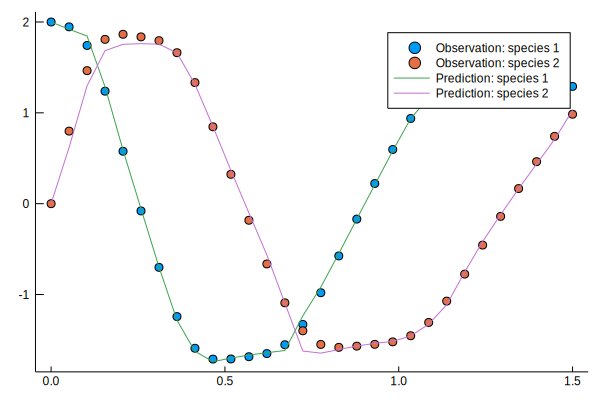

In [12]:
# Plot trained n_ode and observation
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = "Observation: species 1", grid = "off")
scatter!(t, ode_data[2,:], label = "Observation: species 2")
plot!(t, Flux.data(pred[1,:]), label = "Prediction: species 1")
plot!(t, Flux.data(pred[2,:]), label = "Prediction: species 2")
#savefig("sogood.png")
#@save "model_l2_1000_epochs.bson" dudt

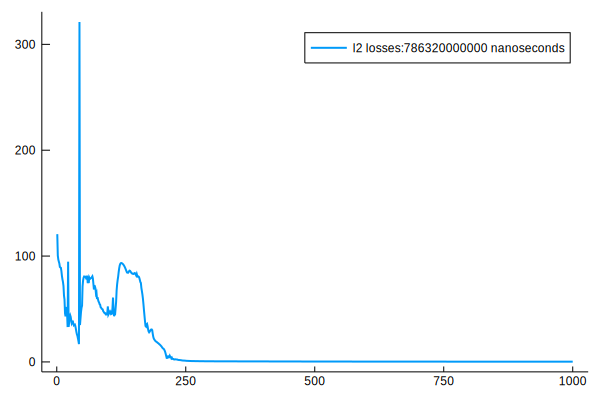

In [29]:
header = string("l2 losses:",sa_l2.times[end]-sa_l2.times[1])
plot(range(1, stop = length(sa_l2.losses)), sa_l2.losses, width = 2, label = header, grid = "off")

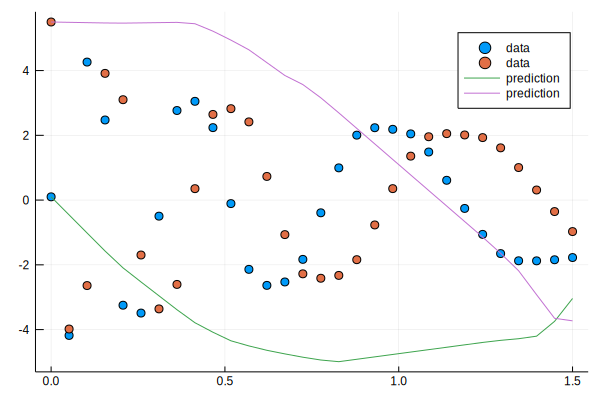

In [20]:
# test other u0
test_u0 = [0.1 , 5.5]
pred_t = n_ode(test_u0)
prob_t = ODEProblem(trueODEfunc, test_u0, tspan)
ode_data_t = Array(solve(prob_t, Tsit5(), saveat = t))
scatter(t, ode_data_t[1,:], label = "data")
scatter!(t, ode_data_t[2,:], label = "data")
plot!(t, Flux.data(pred_t[1,:]), label = "prediction")
plot!(t, Flux.data(pred_t[2,:]), label = "prediction")

In [30]:
44899000000/786320000000

0.05710016278359955

In [1]:
ode_data

UndefVarError: UndefVarError: ode_data not defined